# 라이브러리 로드

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, train_test_split,StratifiedKFold
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix
import sklearn
import matplotlib
import tqdm

###### version
- pandas 1.0.3
- numpy 1.17.4
- sklearn 0.21.3
- lightgbm 2.3.1
- tqdm 4.46.0
- matplotlib 3.1.2
- seaborn 0.9.0

In [4]:
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('sklearn', sklearn.__version__)
print('lightgbm', lgb.__version__)
print('tqdm', tqdm.__version__)
print('matplotlib', matplotlib.__version__)
print('seaborn', sns.__version__)

pandas 1.0.3
numpy 1.17.4
sklearn 0.21.3
lightgbm 2.3.1
tqdm 4.46.0
matplotlib 3.1.2
seaborn 0.9.0


# 데이터 로드

In [5]:
train = pd.read_csv('data/train_features.csv')
train_target = pd.read_csv('data/train_target.csv')
test = pd.read_csv('data/test_features.csv')
submit = pd.read_csv('data/sample_submission.csv')

# 결측값 유무 확인
- 확인 결과 결측값 없음

In [6]:
print(train.isnull().sum())
print(train_target.isnull().sum())
print(test.isnull().sum())

id      0
Time    0
S1      0
S2      0
S3      0
S4      0
dtype: int64
id    0
X     0
Y     0
M     0
V     0
dtype: int64
id      0
Time    0
S1      0
S2      0
S3      0
S4      0
dtype: int64


# target 값 확인
- target 값은 X, Y, M, V 데이터
- X와 Y는 좌표값
- M은 충돌체 질량 (g)
- V는 충돌체 충돌 속도 (m/s)
- 좌표 값인 X,Y 를 일반적인 regression 문제로 생각하고 예측을 해도 될지...
- 데이터들이 아주 균형적으로 샘플링된 느낌.
- 의도적으로 데이터가 샘플링된 것 같음.

In [7]:
train_target.head()

,id,X,Y,M,V
0,0,0.0,-400.0,50.0,0.4
1,1,400.0,0.0,100.0,1.0
2,2,-300.0,-200.0,25.0,0.4
3,3,200.0,-100.0,150.0,0.4
4,4,-300.0,-100.0,150.0,0.4


In [8]:
train_target['X'].value_counts()

-300.0    315
 300.0    315
-200.0    315
 100.0    315
-100.0    315
-400.0    315
 200.0    315
 400.0    315
 0.0      280
Name: X, dtype: int64

In [9]:
train_target['Y'].value_counts()

-300.0    315
 300.0    315
 100.0    315
 200.0    315
-100.0    315
-200.0    315
 0.0      315
-400.0    315
 400.0    280
Name: Y, dtype: int64

In [10]:
train_target['M'].value_counts()

175.0    400
150.0    400
75.0     400
125.0    400
25.0     400
100.0    400
50.0     400
Name: M, dtype: int64

In [11]:
train_target['V'].value_counts()

0.8    560
0.2    560
0.4    560
0.6    560
1.0    560
Name: V, dtype: int64

# Time 데이터
- 일정한 시간 간격으로 S1, S2, S3, S4 지점에서 가속도가 측정되었음.
- 일정한 간격으로 375번 측정된 데이터가 2800개 있음

In [12]:
train['id'].nunique()

2800

In [13]:
train.head()

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0


In [14]:
train.tail()

,id,Time,S1,S2,S3,S4
1049995,2799,0.001480,-89256.32,-164614.6,48186.29,-147910.20
1049996,2799,0.001484,-29233.44,-179404.2,109534.40,-111591.10
1049997,2799,0.001488,37147.25,-190011.7,178781.10,-86836.78
1049998,2799,0.001492,98278.50,-190771.4,245726.70,-75660.00
1049999,2799,0.001496,151683.00,-177267.3,307932.80,-72835.82


###### id 1번

In [15]:
train.iloc[:375]

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.00,0.00,0.00,0.000
1,0,0.000004,0.00,0.00,0.00,0.000
2,0,0.000008,0.00,0.00,0.00,0.000
3,0,0.000012,0.00,0.00,0.00,0.000
4,0,0.000016,0.00,0.00,0.00,0.000
...,...,...,...,...,...,...
370,0,0.001480,-64168.90,-64168.90,52279.59,106792.600
371,0,0.001484,-64236.79,-64236.79,16518.64,58248.420
372,0,0.001488,-63755.95,-63755.95,-25270.30,3015.649
373,0,0.001492,-63020.44,-63020.44,-65904.66,-49795.140


###### id2번

In [16]:
train.iloc[375:375*2]

,id,Time,S1,S2,S3,S4
375,1,0.000000,0.0,0.0,0.00,0.00
376,1,0.000004,0.0,0.0,0.00,0.00
377,1,0.000008,0.0,0.0,0.00,0.00
378,1,0.000012,0.0,0.0,0.00,0.00
379,1,0.000016,0.0,0.0,0.00,0.00
...,...,...,...,...,...,...
745,1,0.001480,962514.8,318184.5,396361.80,-641504.60
746,1,0.001484,1031978.0,354831.0,248709.80,-528058.80
747,1,0.001488,1069688.0,354107.2,93556.34,-394603.00
748,1,0.001492,1068054.0,310828.9,-42801.14,-246912.00


# 각 센서에서 측정된 가속도 (S1, S2, S3, S4)
- 단위 : mm/s^2


#### 시각화

In [25]:
# id 값을 넣으면 S1 ~ S4 순서대로 시각화
def acceleration_show(idx):
    f, axes = plt.subplots(4, 1)
    f.set_size_inches((10, 5)) 
    f.tight_layout() 
    plt.subplots_adjust(bottom=-0.4)
    for i in range(1,5):
        axes[i-1].plot(train[train['id']==idx]['S'+str(i)].values)
        axes[i-1].set_title('S'+str(i))
        axes[i-1].set_xlabel('time')    

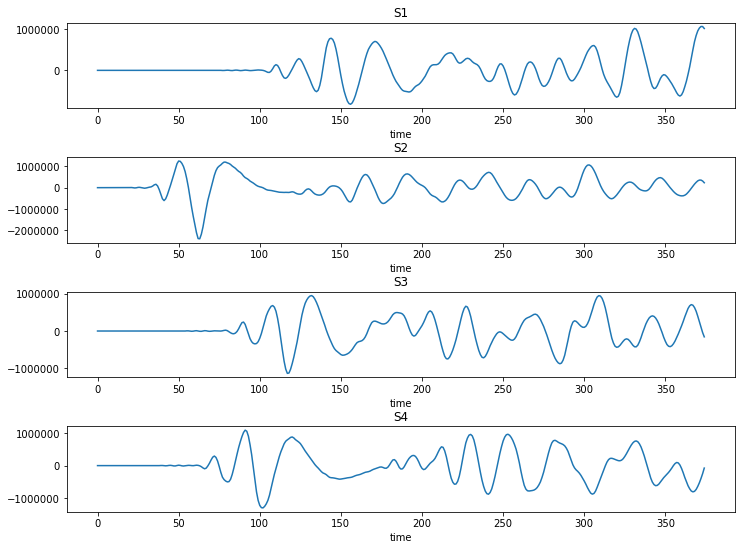

In [18]:
acceleration_show(1)

## train_target 데이터에서 충돌체 질량이 무거운 데이터, 가벼운 데이터를 측정된 가속도와 비교


#### 질량이 무거운 데이터
- 질량이 무거운 데이터는 위아래로 흔들리는 파동이 잦지 않다.

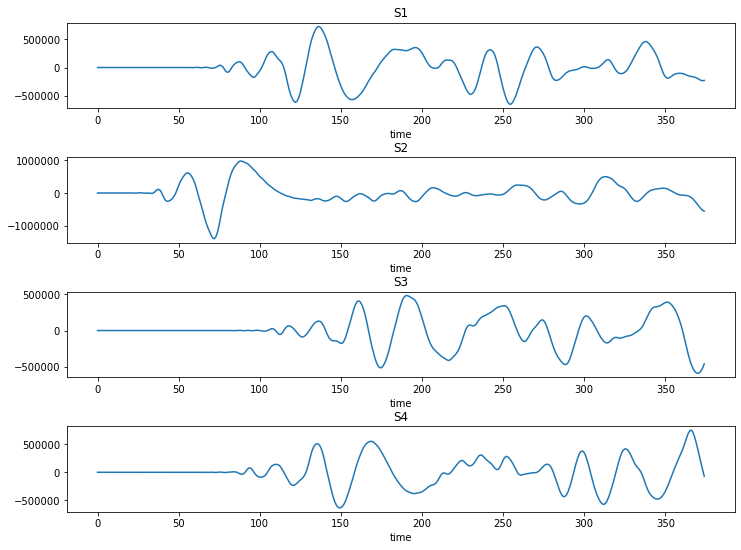

In [17]:
M_175_id = train_target[train_target['M']==175]['id'].values
acceleration_show(M_175_id[1])

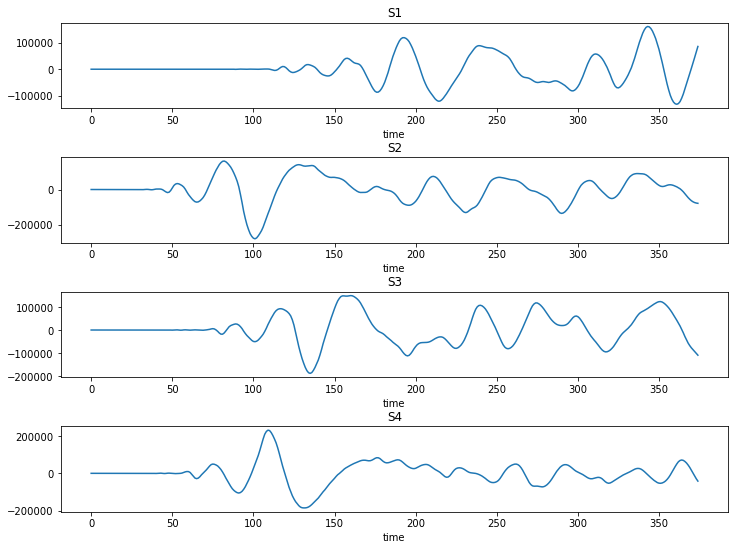

In [18]:
acceleration_show(M_175_id[100])

#### 질량이 가벼운 데이터
- 질량이 가벼운 데이터는 위아래로 흔들리는 파동이 잦다.

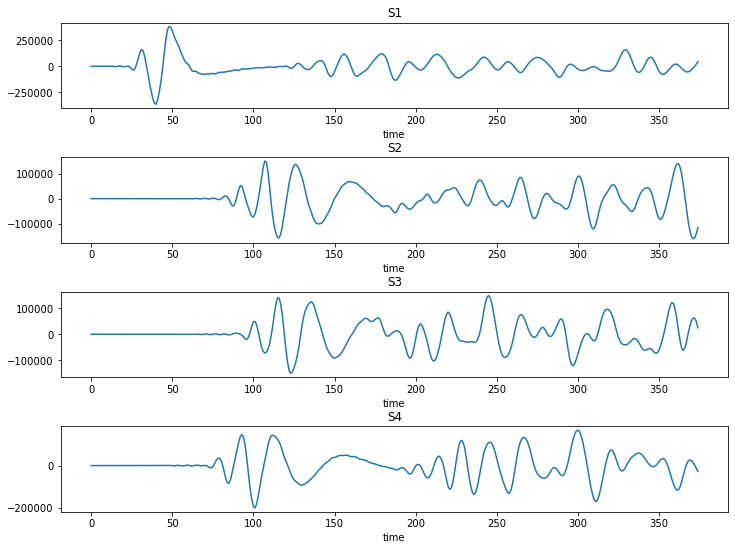

In [19]:
M_25_id = train_target[train_target['M']==25]['id'].values
acceleration_show(M_25_id[0])

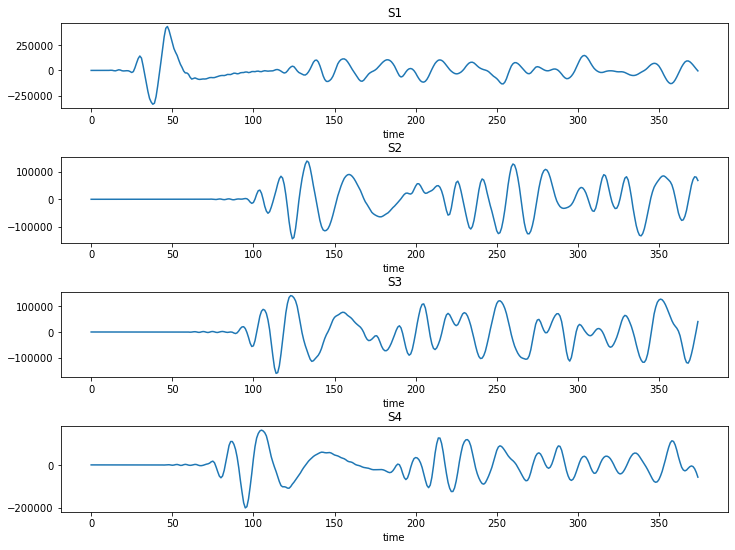

In [20]:
acceleration_show(M_25_id[100])

## train_target 데이터에서 충돌체의 충돌속도와 각 센서에서 측정된 값 비교
- 무게의 비교처럼 한 눈에 보이는 차이점이 보이지 않음.

## 충돌속도 1.0

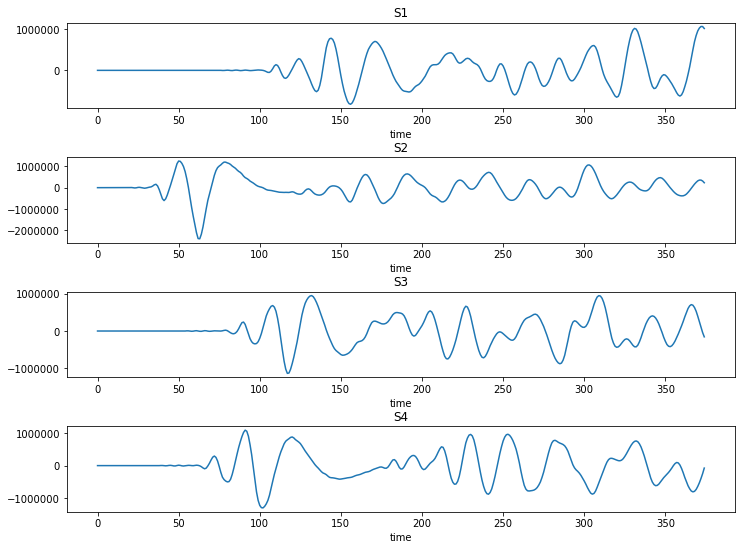

In [21]:
V_1_id = train_target[train_target['V']==1]['id'].values
acceleration_show(V_1_id[0])

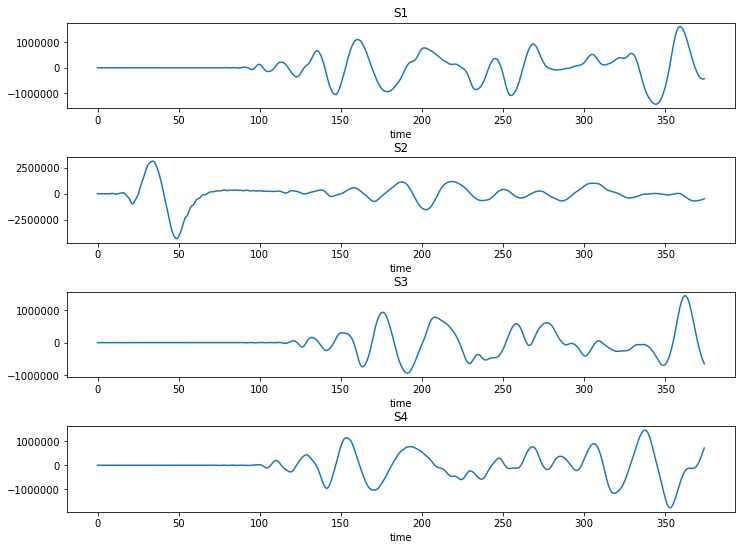

In [22]:
acceleration_show(V_1_id[100])

## 충돌속도0.2

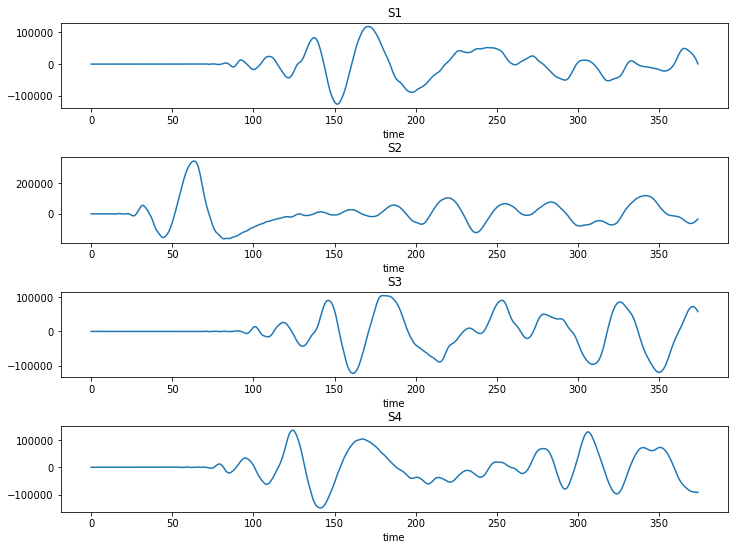

In [23]:
V_02_id = train_target[train_target['V']==0.2]['id'].values
acceleration_show(V_02_id[0])

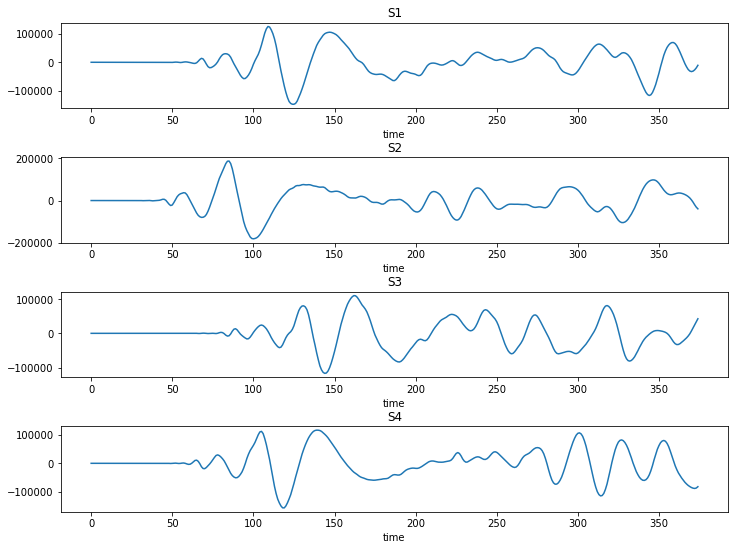

In [24]:
acceleration_show(V_02_id[100])

# X,Y 좌표 데이터
- 정교하게 샘플링이 의도적? 으로 된 것 같은 느낌이 있다.

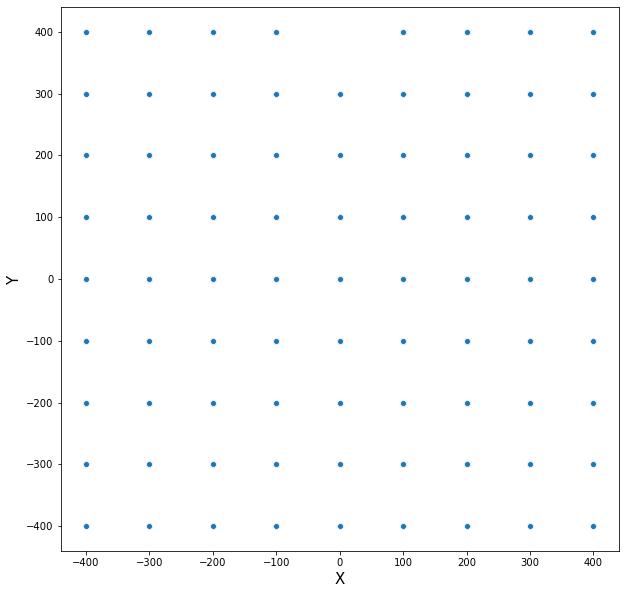

In [25]:
plt.figure(figsize=(10,10))
sns.scatterplot(train_target['X'].values,train_target['Y'].values)
plt.xlabel('X',fontsize=15)
plt.ylabel('Y',fontsize=15)
plt.show()

#### 각각 (x,y) 의 데이터로 만들면 (x,y)가 35개 씩 데이터가 존재하는 것을 알 수 있다.

In [26]:
train_target['X_Y'] = ['{}_{}'.format(x,y) for (x,y) in zip(train_target['X'],train_target['Y'])]
train_target['X_Y'].value_counts()[:10]

0.0_-300.0       35
-300.0_400.0     35
100.0_-300.0     35
-100.0_-100.0    35
100.0_200.0      35
400.0_0.0        35
300.0_400.0      35
400.0_200.0      35
-400.0_-100.0    35
-200.0_200.0     35
Name: X_Y, dtype: int64

## train 과 test의 데이터의 분포는 동일할까?- Adversarial Validation
- train과 test의 센서측정 데이터들을 단순히 1차원으로 만든다.
- train과 test 데이터들을 합친후 train은 0으로 test는 1로 train과 test의 분포는 test의 갯수에 맞게 under-sampling하여 700개씩 총 1400개로 만든다.
- 1,0 분류실험을 통해 train과 test를 잘 분류 하는지 실험.
- 만약 잘 분류를 하지 못하면 train의 데이터의 분포는 test와 같을 것이고, 잘 분류한다면 분포는 다를 것이라 예상됨.
- 실험결과 아주 잘 분류한다. --> train과 test의 분포는 약간 다르다.
- train의 데이터들은 잘 샘플링된 데이터인 반면 test 데이터는 그렇지 않을 것이라 예상된다. 즉, X, Y가 딱 떨어지지 않을 것이라 예상.
- 충돌체의 무게와 속도 또한 그러할 것 같음.

#### train 데이터 같은 id의 S1~S4를 1차원으로 변형

In [27]:
from tqdm.notebook import tqdm
train_ = []
for ID in tqdm(train['id'].unique()):
    tmp_df = train[train['id'] == ID]
    tmp_X = []
    tmp_X.append(tmp_df['S1'].values)
    tmp_X.append(tmp_df['S2'].values)
    tmp_X.append(tmp_df['S3'].values)
    tmp_X.append(tmp_df['S4'].values)
    train_.append(tmp_X)
train_=np.array(train_).reshape(train['id'].nunique(), -1)

#### test 데이터 같은 id의 S1~S4를 1차원으로 변형

In [28]:
test_ = []
for ID in tqdm(test['id'].unique()):
    tmp_df = test[test['id'] == ID]
    tmp_X = []
    tmp_X.append(tmp_df['S1'].values)
    tmp_X.append(tmp_df['S2'].values)
    tmp_X.append(tmp_df['S3'].values)
    tmp_X.append(tmp_df['S4'].values)
    test_.append(tmp_X)
test_=np.array(test_).reshape(test['id'].nunique(), -1)

#### train과 test의 분포를 같게 만들어준다. 1:1 비율로. --> train:700개, test: 700개

In [29]:
np.random.seed(42)
choice_idxs = np.random.choice(range(len(train_)),len(test_), replace=False)
X_train_test = np.concatenate([train_[choice_idxs], test_])
y_train_test = np.array([0 for _ in range(len(choice_idxs))] + [1 for _ in range(test['id'].nunique())])

#### 학습할 수 있도록 데이터를 분리.
- 층화추출을 통해 데이터 분리를 할 때 분포가 비슷하도록 만들어줌.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.2, random_state=42, stratify=y_train_test)

#### LightGBM로 분류하는 모델을 만들어본다.
- 파라미터는 기본값.
- 200 번 동안 성능 개선 없을 시 중단하고 best score를 저장

In [31]:

params = {    
    'objective': 'binary',
    'metrics':'auc'
} 
train_set = lgb.Dataset(X_train, y_train)
test_set = lgb.Dataset(X_test, y_test)
lgb_model = lgb.train(params, train_set, 1000, early_stopping_rounds=200, 
            valid_sets=[train_set, test_set],
            verbose_eval=50,
           )

Training until validation scores don't improve for 200 rounds
[50]	training's auc: 1	valid_1's auc: 0.976735
[100]	training's auc: 1	valid_1's auc: 0.982347
[150]	training's auc: 1	valid_1's auc: 0.985714
[200]	training's auc: 1	valid_1's auc: 0.986531
[250]	training's auc: 1	valid_1's auc: 0.98648
[300]	training's auc: 1	valid_1's auc: 0.987092
[350]	training's auc: 1	valid_1's auc: 0.987755
[400]	training's auc: 1	valid_1's auc: 0.98801
[450]	training's auc: 1	valid_1's auc: 0.987653
[500]	training's auc: 1	valid_1's auc: 0.987296
[550]	training's auc: 1	valid_1's auc: 0.987398
[600]	training's auc: 1	valid_1's auc: 0.987398
Early stopping, best iteration is:
[402]	training's auc: 1	valid_1's auc: 0.988061


#### 예측결과
- 훌륭하게 잘 분류를 해내는 것을 볼 수 있음. --> train과 test의 분포가 약간 다르다.
- 보통 랜덤하게 분리된 데이터들은 정확도가 0.5에 가깝게 예측됨. 즉 모델도 뭐가 정답인지 몰라 랜덤으로 찍는 정도.

In [32]:
pred = lgb_model.predict(X_test)
pred = np.where(pred>=0.5, 1,0)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94       140
           1       0.94      0.93      0.94       140

    accuracy                           0.94       280
   macro avg       0.94      0.94      0.94       280
weighted avg       0.94      0.94      0.94       280

[[132   8]
 [ 10 130]]


#### 어떠한 데이터가 있는지. 어떤 형태로 존재하는지 한 번 훝어보았습니다.
#### 데이터를 보면서 제 의견도 일부 포함되었습니다. 틀린 의견이 존재할 수 있습니다. 피드백 해주세요 !